# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Hydro Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\hydro_production_dataset.csv')

data.head()

,Country,Date,Value,Precipitation
0,Australia,2023-03-01,1215.8041,0.080641
1,Australia,2023-02-01,942.5558,0.127869
2,Australia,2023-01-01,1190.7296,0.159242
3,Australia,2022-12-01,1110.1523,0.105662
4,Australia,2022-11-01,1397.5839,0.073524


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

hydro_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'Hydro' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Precipitation']
    ]
    
    # Store the filtered data in the dictionary
    hydro_production_data[country] = country_energy_production.reset_index(drop=True)

hydro_production_data["People's Republic of China"]

,Date,Value,Precipitation
0,2023-03-01,73945.8791,0.047892
1,2023-02-01,72451.0580,0.034664
2,2023-01-01,75408.2440,0.018350
3,2022-12-01,80826.5783,0.015956
4,2022-11-01,84331.8402,0.051384
...,...,...,...
94,2015-05-01,85670.2270,0.133786
95,2015-04-01,78410.0390,0.078497
96,2015-03-01,75539.4720,0.048017
97,2015-02-01,52697.8010,0.035847


# Resample to daily data

In [4]:
# hypro_production_data
for country_data in hydro_production_data:
    
    # set time as the index
    hydro_production_data[country_data]['Date'] = pd.to_datetime(hydro_production_data[country_data]['Date'])
    hydro_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    hydro_production_data[country_data]['Value'] = (hydro_production_data[country_data]['Value']/
                                                    hydro_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = hydro_production_data[country_data].resample('D').interpolate('linear')
    hydro_production_data[country_data] = daily_data
    
hydro_production_data["People's Republic of China"]

,Value,Precipitation
Date,,
2015-01-01,2036.455935,0.029145
2015-01-02,2031.475561,0.029361
2015-01-03,2026.495186,0.029578
2015-01-04,2021.514812,0.029794
2015-01-05,2016.534437,0.030010
...,...,...
2023-02-25,2414.234774,0.046002
2023-02-26,2407.013815,0.046475
2023-02-27,2399.792856,0.046947


## Split Train and Test Data

In [5]:
data = hydro_production_data["People's Republic of China"]

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                  Value
Date                   
2015-01-01  2036.455935
2015-01-02  2031.475561
2015-01-03  2026.495186
2015-01-04  2021.514812
2015-01-05  2016.534437
(2193, 1)

                  Value
Date                   
2021-01-01  2697.638755
2021-01-02  2675.345547
2021-01-03  2653.052339
2021-01-04  2630.759132
2021-01-05  2608.465924
(790, 1)


## Univariate - ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,1)(0,1,0)[365] 
#### Figure below show the result from R:
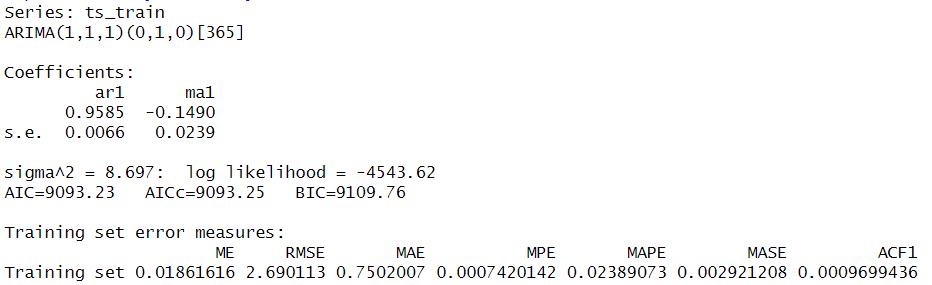

In [62]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
chn_hydro_arima_model = r_load("F:\APU\FYP\SEM 2\Report Doc\R script\chn_hydro_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [63]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(chn_hydro_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test.values))
mse = mean_squared_error(predictions.rx('mean')[0], test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  958.991860436371
Mean Squared Error:  1280083.764102779
Root Mean Squared Error:  1131.4078681460453


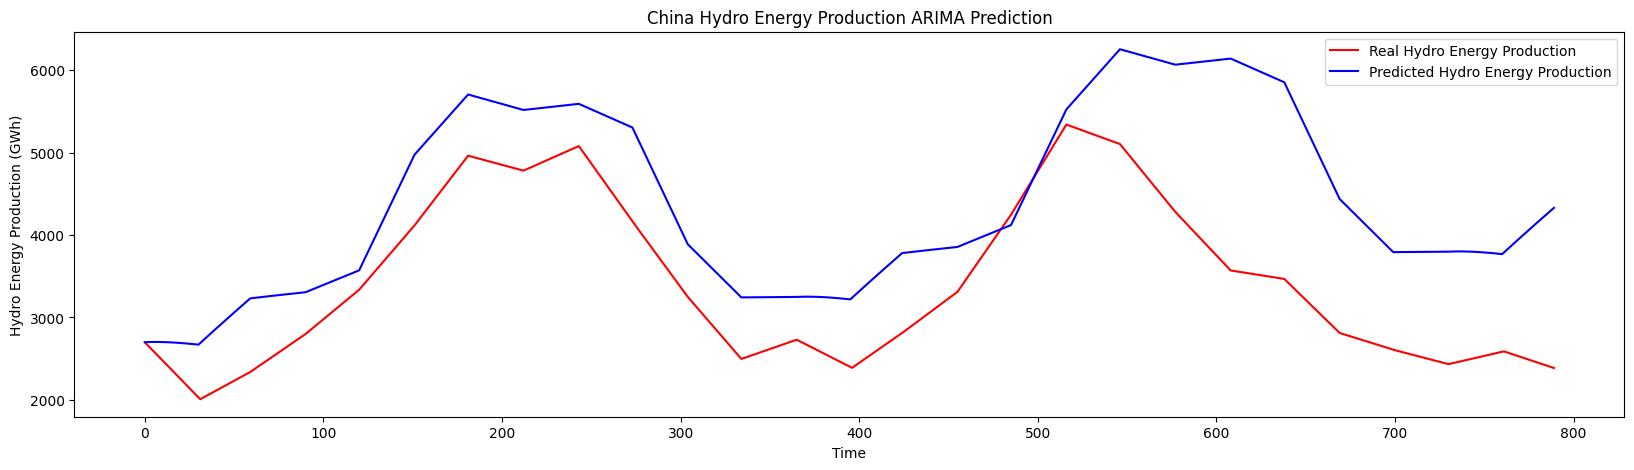

In [64]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('China Hydro Energy Production ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy Production (GWh)')
plt.legend()
plt.show()

## Univariate - SVR - Daily

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [65]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(1828, 365) (1828,)


In [66]:
# Build and Train the SVM Model
chn_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01)
chn_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [67]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Hydro Energy Production
svr_y_pred = chn_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(y_pred.shape)

(790, 1)


In [68]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  713.653711728983
Mean Squared Error:  1206.1764758468353
Root Mean Squared Error:  34.7300514806246


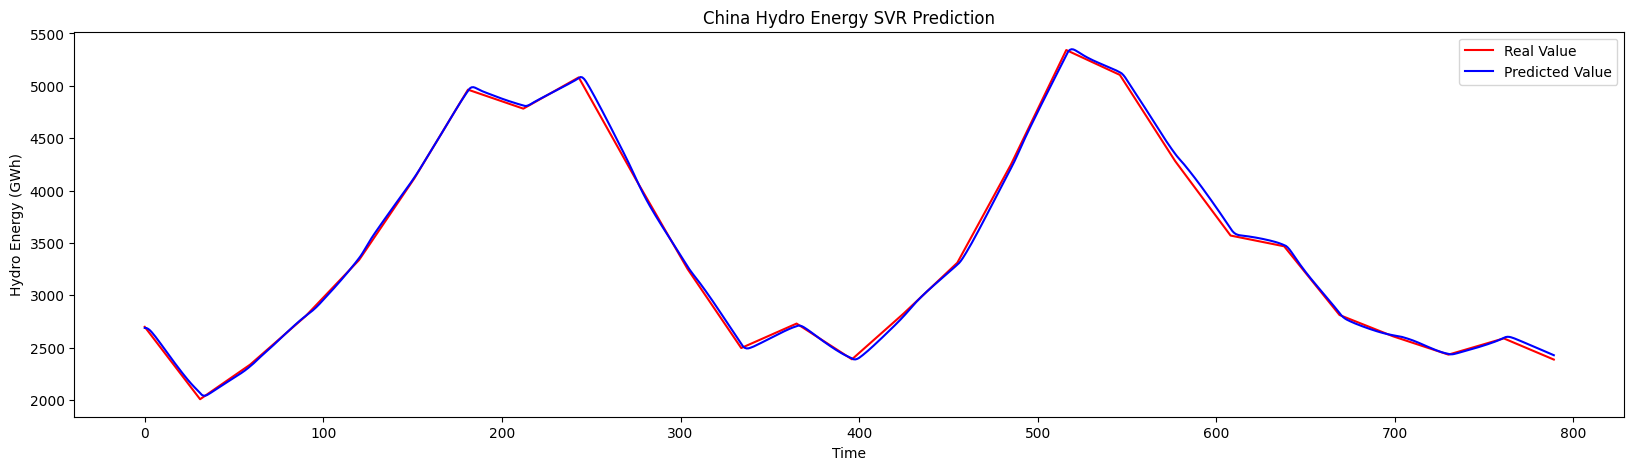

In [69]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('China Hydro Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate ANN - Daily

In [46]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

In [47]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test.values, time_steps)

X_train.shape

(1828, 365, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

# Create the model
chn_daily_ann = Sequential()
chn_daily_ann.add(Dense(84, activation='tanh', input_shape=(365,)))
chn_daily_ann.add(Dropout(0.2))
chn_daily_ann.add(Dense(1, activation='linear'))

chn_daily_ann.compile(optimizer='adam', loss='mean_squared_error')

chn_daily_ann.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
115/115 [==============================] - 12s 4ms/step - loss: 0.0725
Epoch 2/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0195
Epoch 3/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 5/100
115/115 [==============================] - 1s 6ms/step - loss: 0.0094
Epoch 6/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 8/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 9/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 10/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 11/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 12/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 13/100

In [48]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

ann_y_pred = chn_daily_ann.predict(X_test)
ann_y_pred = sc.inverse_transform(ann_y_pred)

print("Mean Absolute Error: ", mean_absolute_error(ann_y_pred, test.values))
mse = mean_squared_error(ann_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

25/25 [==============================] - 4s 20ms/step
Mean Absolute Error:  115.07239416398616
Mean Squared Error:  16882.537589251628
Root Mean Squared Error:  129.93281952321217


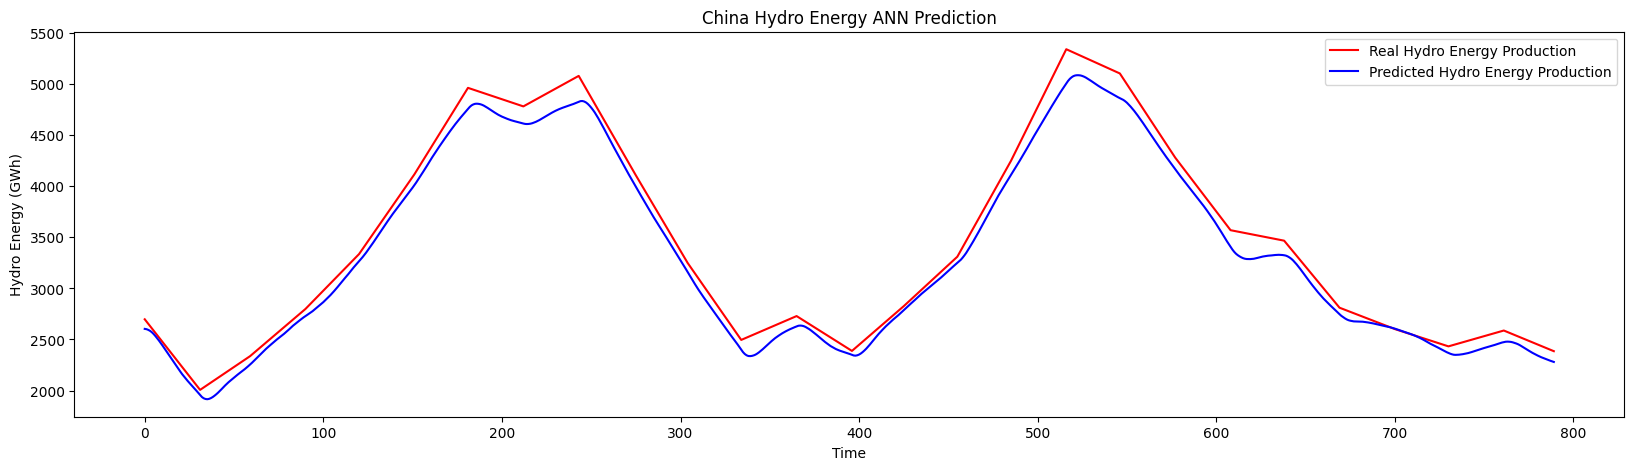

In [49]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(ann_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('China Hydro Energy ANN Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [50]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.04714802]
 [0.04562712]
 [0.04410621]
 ...
 [0.24896946]
 [0.24901455]
 [0.24905963]]
(2193, 1)


In [18]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-365:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
print(X_train)
X_train.shape

[[0.04714802 0.04562712 0.04410621 ... 0.20750172 0.20881563 0.21012954]
 [0.04562712 0.04410621 0.04258531 ... 0.20881563 0.21012954 0.21144346]
 [0.04410621 0.04258531 0.0410644  ... 0.21012954 0.21144346 0.20664616]
 ...
 [0.11879373 0.11726423 0.11613175 ... 0.2488342  0.24887929 0.24892437]
 [0.11726423 0.11613175 0.11499927 ... 0.24887929 0.24892437 0.24896946]
 [0.11613175 0.11499927 0.11386679 ... 0.24892437 0.24896946 0.24901455]]


(1828, 365)

In [20]:
print(y_train)
y_train.shape

[0.21144346 0.20664616 0.20184887 ... 0.24896946 0.24901455 0.24905963]


(1828,)

In [21]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [23]:
# Initialising the RNN
chn_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
chn_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
chn_daily_uni_lstm.add(Dropout(0.2))

chn_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
chn_daily_uni_lstm.add(Dropout(0.2))

chn_daily_uni_lstm.add(LSTM(units = 64))
chn_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
chn_daily_uni_lstm.add(Dense(units = 1))

In [24]:
# Compiling the RNN
chn_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
chn_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
58/58 [==============================] - 156s 808ms/step - loss: 0.0204
Epoch 2/100
58/58 [==============================] - 45s 782ms/step - loss: 0.0039
Epoch 3/100
58/58 [==============================] - 47s 813ms/step - loss: 0.0033
Epoch 4/100
58/58 [==============================] - 48s 823ms/step - loss: 0.0027
Epoch 5/100
58/58 [==============================] - 45s 785ms/step - loss: 0.0025
Epoch 6/100
58/58 [==============================] - 46s 792ms/step - loss: 0.0024
Epoch 7/100
58/58 [==============================] - 49s 853ms/step - loss: 0.0019
Epoch 8/100
58/58 [==============================] - 52s 895ms/step - loss: 0.0020
Epoch 9/100
58/58 [==============================] - 48s 836ms/step - loss: 0.0020
Epoch 10/100
58/58 [==============================] - 44s 761ms/step - loss: 0.0017
Epoch 11/100
58/58 [==============================] - 45s 777ms/step - loss: 0.0017
Epoch 12/100
58/58 [==============================] - 44s 768ms/step - loss: 0.0017


In [25]:
test[['Value']].shape

(790, 1)

In [51]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = chn_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 10s 254ms/step


In [52]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test.values))
mse = mean_squared_error(uni_lstm_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  23.79116568238463
Mean Squared Error:  932.4328992531684
Root Mean Squared Error:  30.535764265090343


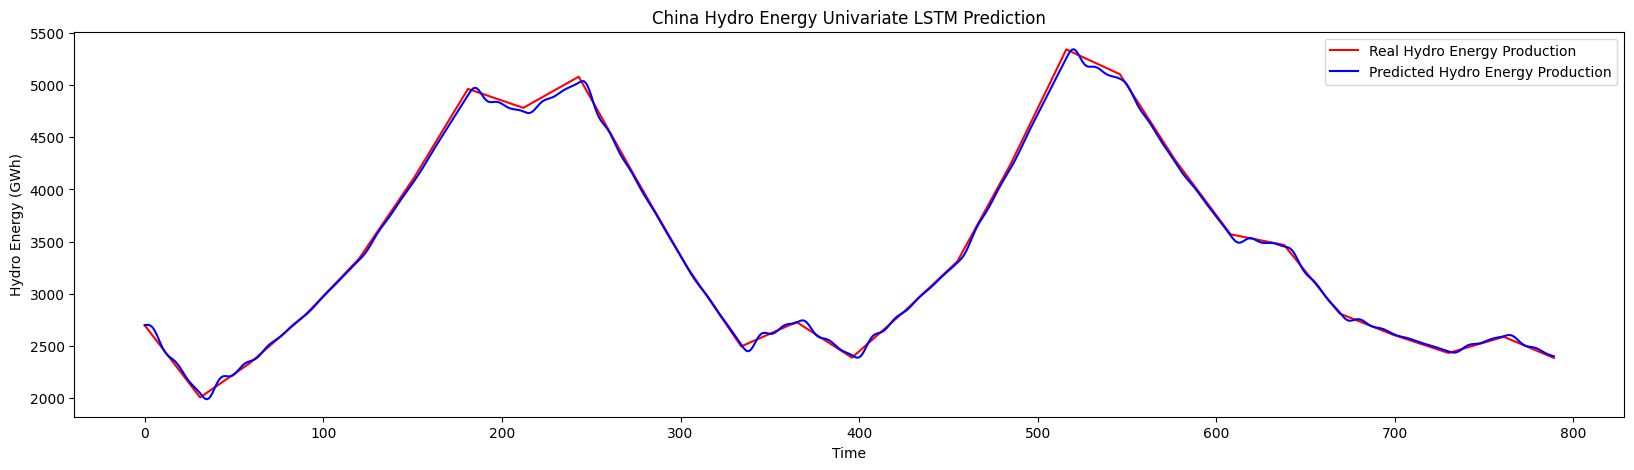

In [53]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('China Hydro Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [29]:
data = hydro_production_data["People's Republic of China"]

data.shape

(2982, 2)

In [54]:
X = data[['Precipitation', 'Value']]
y = data[['Value']]

X.head()

,Precipitation,Value
Date,,
2015-01-01,0.029145,2036.455935
2015-01-02,0.029361,2031.475561
2015-01-03,0.029578,2026.495186
2015-01-04,0.029794,2021.514812
2015-01-05,0.030010,2016.534437


In [55]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [56]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [33]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(2193, 2)
(790, 2)

(2193, 1)
(790, 1)


In [34]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

print(X_train1.shape)

(1828, 365, 2)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

chn_daily_multi_lstm = Sequential()
chn_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(LSTM(units = 64))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(Dense(1))

In [36]:
chn_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

chn_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 136s 976ms/step - loss: 0.0247
Epoch 2/100
58/58 [==============================] - 48s 833ms/step - loss: 0.0044
Epoch 3/100
58/58 [==============================] - 55s 954ms/step - loss: 0.0034
Epoch 4/100
58/58 [==============================] - 60s 1s/step - loss: 0.0031
Epoch 5/100
58/58 [==============================] - 56s 958ms/step - loss: 0.0027
Epoch 6/100
58/58 [==============================] - 58s 1s/step - loss: 0.0028
Epoch 7/100
58/58 [==============================] - 55s 953ms/step - loss: 0.0022
Epoch 8/100
58/58 [==============================] - 53s 911ms/step - loss: 0.0020
Epoch 9/100
58/58 [==============================] - 55s 952ms/step - loss: 0.0020
Epoch 10/100
58/58 [==============================] - 57s 994ms/step - loss: 0.0022
Epoch 11/100
58/58 [==============================] - 52s 900ms/step - loss: 0.0020
Epoch 12/100
58/58 [==============================] - 55s 944ms/step - loss: 0.0019
Epoch 

58/58 [==============================] - 46s 790ms/step - loss: 5.0938e-04
Epoch 97/100
58/58 [==============================] - 48s 833ms/step - loss: 5.1068e-04
Epoch 98/100
58/58 [==============================] - 48s 822ms/step - loss: 4.8940e-04
Epoch 99/100
58/58 [==============================] - 48s 826ms/step - loss: 4.8282e-04
Epoch 100/100
58/58 [==============================] - 47s 805ms/step - loss: 5.7879e-04


In [57]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)

X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = chn_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)

25/25 [==============================] - 8s 252ms/step


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  38.89426373952428
Mean Squared Error:  2276.140334691792
Root Mean Squared Error:  47.70891252891635


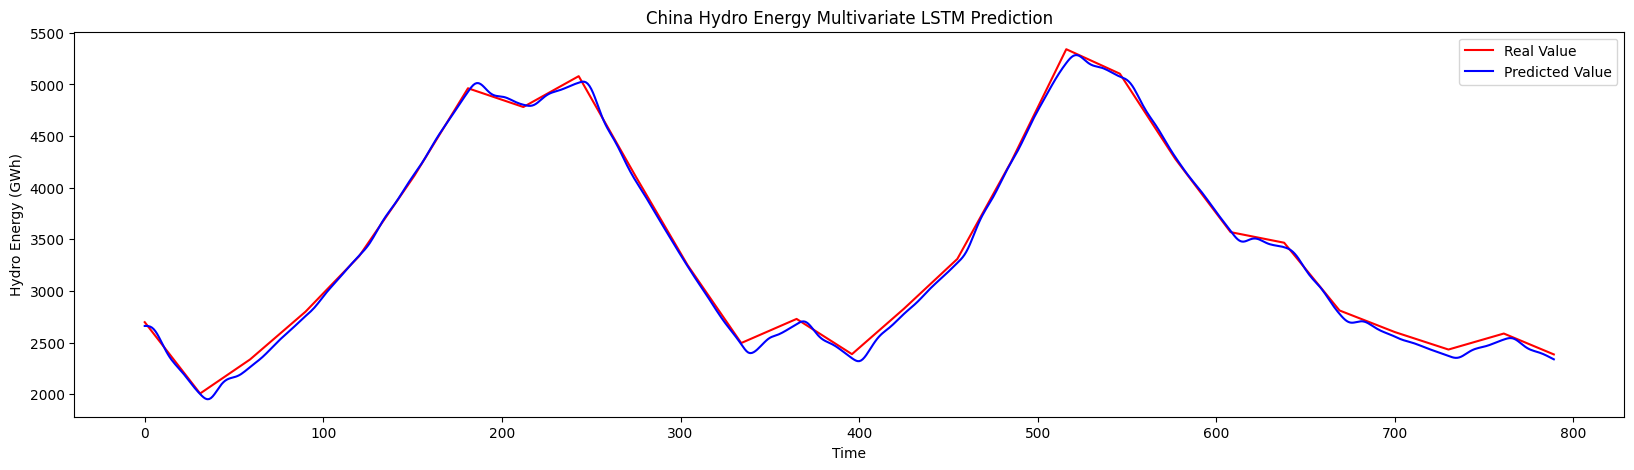

In [60]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('China Hydro Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Overview

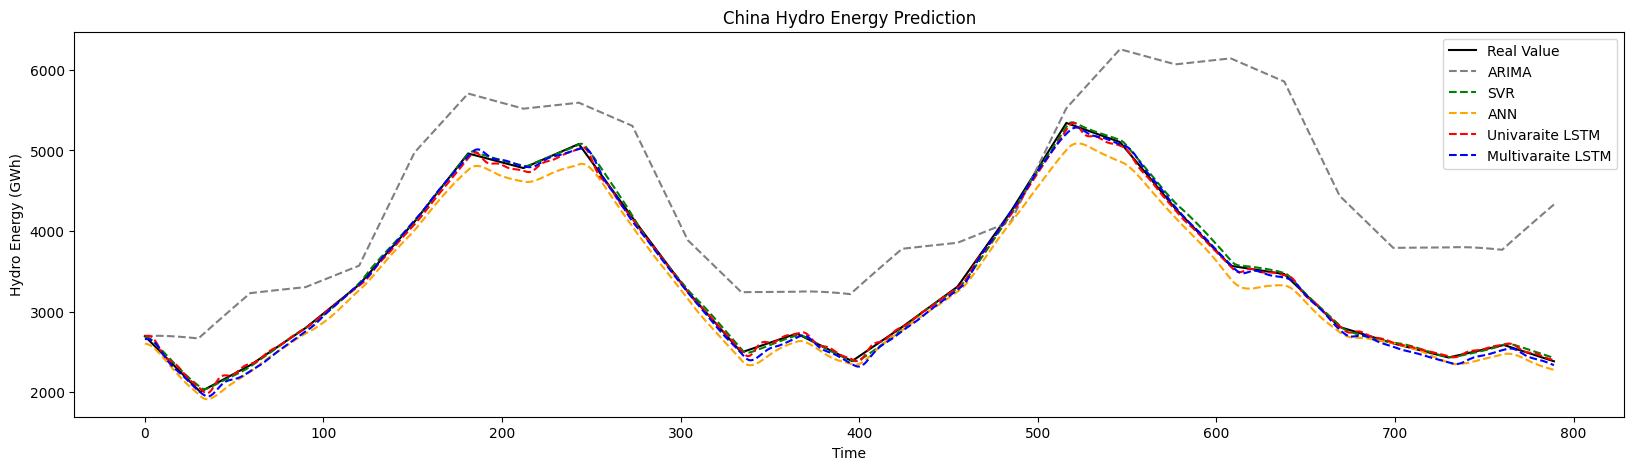

In [70]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(ann_y_pred, color='orange', linestyle='--', label='ANN')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('China Hydro Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [40]:
chn_daily_uni_lstm.save('chn_hydro_best_uni_lstm.h5')

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
